In [1]:
cd ../

/Users/linafaik/Documents/projects/time-series-forecasting-models


/Users/linafaik/Documents/projects/time-series-forecasting-models/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np
import os

from nixtla import NixtlaClient
import shap
import matplotlib.pyplot as plt

from config import *
from src.data_processing import *
from src.metrics import *
from src.training import *
from src.viz import *

%load_ext autoreload
%autoreload 2


/Users/linafaik/Documents/projects/time-series-forecasting-models/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
client = NixtlaClient(api_key=NIXTLA_API_KEY)

In [5]:
force = True

In [6]:
df = pd.read_csv(path_data_processed)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

df.head()

,date,store_id,state_id,sold_quantity,sold_amount,event_type_1,event_type_2,event_sporting,event_cultural,event_national,event_religious
0,2011-01-29,CA_1,CA,4337,10933.16,NaN,NaN,0,0,0,0
1,2011-01-29,CA_2,CA,3494,9101.52,NaN,NaN,0,0,0,0
2,2011-01-29,CA_3,CA,4739,11679.83,NaN,NaN,0,0,0,0
3,2011-01-29,CA_4,CA,1625,4561.59,NaN,NaN,0,0,0,0
4,2011-01-29,TX_1,TX,2556,6586.68,NaN,NaN,0,0,0,0


## Data loading

In [7]:
df = pd.read_csv(path_data_processed)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

df.head()

,date,store_id,state_id,sold_quantity,sold_amount,event_type_1,event_type_2,event_sporting,event_cultural,event_national,event_religious
0,2011-01-29,CA_1,CA,4337,10933.16,NaN,NaN,0,0,0,0
1,2011-01-29,CA_2,CA,3494,9101.52,NaN,NaN,0,0,0,0
2,2011-01-29,CA_3,CA,4739,11679.83,NaN,NaN,0,0,0,0
3,2011-01-29,CA_4,CA,1625,4561.59,NaN,NaN,0,0,0,0
4,2011-01-29,TX_1,TX,2556,6586.68,NaN,NaN,0,0,0,0


## Uncertainty quantification

In [8]:
name_scenario = "timegpt_with_ci"

In [9]:
path = os.path.join("output", name_scenario, f"forecasts_{name_scenario}.csv")

if force or not os.path.exists(path):
    
    train_df, test_df = split_train_test(
        df=df, 
        horizon=H,
        column_date=time_col,
        column_id=id_col,
        )

    print(f"{len(train_df)} rows for train")
    print(f"{len(test_df)} rows for test")

    columns_exog_features = ["event_cultural", "event_national", "event_religious", "event_sporting"]
    
    forecasts_df = client.forecast(
        df=train_df[[time_col, target_col, id_col]+columns_exog_features],
        X_df=test_df[[time_col, target_col, id_col]+columns_exog_features],
        id_col=id_col,
        time_col=time_col,
        target_col=target_col,
        h=H,
        freq=freq,
        finetune_steps=10,
        finetune_loss="rmse",
        finetune_depth=3, 
        model="timegpt-1-long-horizon",
        date_features=True,
        date_features_to_one_hot=False,
        level=[90]
    )
    
    forecasts_enr_df = ( 
        test_df
        .merge(forecasts_df, on=[id_col, time_col], how="left")
    )
    
    forecasts_enr_df = pd.concat([train_df, forecasts_enr_df], axis=0).reset_index(drop=True)

    os.makedirs(os.path.join("output", name_scenario), exist_ok=True)
    forecasts_enr_df.to_csv(path, index=False)

else:
    forecasts_enr_df = pd.read_csv(path)

forecasts_enr_df.tail()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


19270 rows for train
140 rows for test


INFO:nixtla.nixtla_client:Using future exogenous features: ['event_cultural', 'event_national', 'event_religious', 'event_sporting', 'year', 'month', 'day', 'weekday']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,date,store_id,state_id,sold_quantity,sold_amount,event_type_1,event_type_2,event_sporting,event_cultural,event_national,event_religious,TimeGPT,TimeGPT-hi-90,TimeGPT-lo-90
19405,2016-05-18,WI_3,WI,3268,9163.29,NaN,NaN,0,0,0,0,9554.804,11989.408,7120.1987
19406,2016-05-19,WI_3,WI,3398,9660.13,NaN,NaN,0,0,0,0,9733.679,11269.761,8197.5970
19407,2016-05-20,WI_3,WI,4126,11982.37,NaN,NaN,0,0,0,0,11154.428,12823.261,9485.5950
19408,2016-05-21,WI_3,WI,4519,12370.23,NaN,NaN,0,0,0,0,13318.895,15348.429,11289.3600
19409,2016-05-22,WI_3,WI,4757,13432.85,NaN,NaN,0,0,0,0,12950.488,15007.972,10893.0050


In [10]:
# Initialize containers:
# - `scores` will store overall evaluation metrics for the model
# - `scores_per_ts` will store evaluation metrics per time series (per ID)
scores = {}
scores_per_ts = []

# Loop through the list of model forecast columns (here only 'TimeLLM')
for column in ['TimeGPT']:
    
    # Filter out rows where the model forecast is missing (NaN)
    forecasts_filtered_df = forecasts_enr_df[forecasts_enr_df[column].notna()]
    
    # Compute global evaluation metrics (e.g., MAE, RMSE) for TimeLLM
    scores[column] = evaluate(
        forecasts_filtered_df[target_col],    # Ground truth
        forecasts_filtered_df[column]         # Model forecast
    )
    
    # Compute evaluation metrics per time series (grouped by id_col)
    scores_per_ts_model_df = (
        forecasts_filtered_df
        .groupby(id_col)
        .apply(lambda group: pd.Series(
            evaluate(group[target_col], group[column])  # Metrics per time series
        ))
        .reset_index()
    )
    
    # Add a column to tag each row with the model name
    scores_per_ts_model_df["model"] = column
    
    # Append only relevant columns to the results list
    scores_per_ts.append(
        scores_per_ts_model_df[["model"] + [c for c in scores_per_ts_model_df.columns if c != "model"]]
    )

# Convert the global scores dictionary into a DataFrame
scores_df = (
    pd.DataFrame(scores).T
    .reset_index()
    .rename(columns={"index": "model"})
)

# Concatenate all time-series-level score DataFrames into a single table
scores_per_ts_df = pd.concat(scores_per_ts, axis=0).reset_index(drop=True)
scores_df

/var/folders/x1/5lcr60ps53nfbsvw0s9dt0640000gn/T/ipykernel_38577/3488599734.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  forecasts_filtered_df


,model,MAE,RMSE,MAPE,R2,count
0,TimeGPT,929.515206,1.581625e+06,0.062514,0.907303,140.0


In [11]:
rnd_id = np.random.choice(scores_per_ts_df[id_col].unique())

plot_forecast_with_ci(
    forecasts_enr_df, 
    column_id=id_col,
    column_date=time_col,
    column_target=target_col,
    column_forecast="TimeGPT",
    uid=rnd_id, 
    model_name="TimeGPT",
    level=90, 
    train_tail=30
    )


/Users/linafaik/Documents/projects/time-series-forecasting-models/src/viz.py:183: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fc = forecast_uid_df[forecast_df[lower_q].notna()]
/Users/linafaik/Documents/projects/time-series-forecasting-models/src/viz.py:184: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test = forecast_uid_df[forecast_df[lower_q].notna()]
/Users/linafaik/Documents/projects/time-series-forecasting-models/src/viz.py:185: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = forecast_uid_df[forecast_df[lower_q].isna()]


## Shape value

In [19]:
path = os.path.join("output", name_scenario, f"forecasts_{name_scenario}.csv")

if force or not os.path.exists(path):
    
    train_df, test_df = split_train_test(
        df=df, 
        horizon=H,
        column_date=time_col,
        column_id=id_col,
        )

    print(f"{len(train_df)} rows for train")
    print(f"{len(test_df)} rows for test")

    columns_exog_features = ["event_cultural", "event_national", "event_religious", "event_sporting"]
    
    forecasts_df = client.forecast(
        df=train_df[[time_col, target_col, id_col]+columns_exog_features],
        X_df=test_df[[time_col, target_col, id_col]+columns_exog_features],
        id_col=id_col,
        time_col=time_col,
        target_col=target_col,
        h=H,
        freq=freq,
        finetune_steps=10,
        finetune_loss="rmse",
        finetune_depth=3, 
        model="timegpt-1-long-horizon",
        date_features=True,
        date_features_to_one_hot=False,
        clean_ex_first=True,
        feature_contributions=True
    )
    
    forecasts_enr_df = ( 
        test_df
        .merge(forecasts_df, on=[id_col, time_col], how="left")
    )
    
    forecasts_enr_df = pd.concat([train_df, forecasts_enr_df], axis=0).reset_index(drop=True)

    os.makedirs(os.path.join("output", name_scenario), exist_ok=True)
    forecasts_enr_df.to_csv(path, index=False)

else:
    forecasts_enr_df = pd.read_csv(path)

forecasts_enr_df.tail()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['event_cultural', 'event_national', 'event_religious', 'event_sporting', 'year', 'month', 'day', 'weekday']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


19270 rows for train
140 rows for test


,date,store_id,state_id,sold_quantity,sold_amount,event_type_1,event_type_2,event_sporting,event_cultural,event_national,event_religious,TimeGPT
19405,2016-05-18,WI_3,WI,3268,9163.29,NaN,NaN,0,0,0,0,9562.166
19406,2016-05-19,WI_3,WI,3398,9660.13,NaN,NaN,0,0,0,0,9743.489
19407,2016-05-20,WI_3,WI,4126,11982.37,NaN,NaN,0,0,0,0,11169.223
19408,2016-05-21,WI_3,WI,4519,12370.23,NaN,NaN,0,0,0,0,13329.262
19409,2016-05-22,WI_3,WI,4757,13432.85,NaN,NaN,0,0,0,0,12962.226


In [20]:
shap_df = client.feature_contributions
shap_df.head()

,store_id,date,TimeGPT,event_cultural,event_national,event_religious,event_sporting,year,month,day,weekday,base_value
0,CA_1,2016-05-09,14999.121,17.527464,-29.779165,-1.663453,3.845909,4102.4890,396.40433,611.7991,-652.75410,10551.2510
1,CA_1,2016-05-10,13722.821,16.330610,14.060459,-1.663453,3.699214,4139.7420,408.87885,387.2594,-1476.98100,10231.4950
2,CA_1,2016-05-11,13225.071,16.931772,12.429682,-1.919315,3.827060,4048.3718,255.68626,649.2640,-1698.49980,9938.9795
3,CA_1,2016-05-12,13003.996,17.072605,12.359237,-2.823807,3.825990,3992.6890,176.10540,569.8088,-1621.53760,9856.4970
4,CA_1,2016-05-13,14557.518,17.306437,26.423294,-3.769055,3.699957,3984.5938,234.25844,210.8523,-309.61465,10393.7670


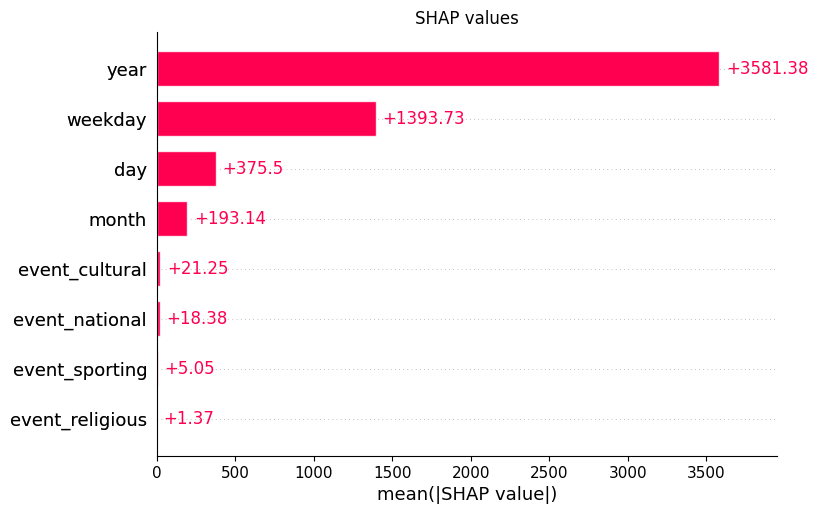

In [21]:
shap_columns = shap_df.columns.difference([id_col, time_col, 'TimeGPT', 'base_value'])

shap_obj = shap.Explanation(
    values=shap_df[shap_columns].values,
    base_values=shap_df['base_value'].values,
    feature_names=shap_columns
)

shap.plots.bar(
    shap_obj,
    max_display=len(shap_columns),
    show=False
)

plt.title(f'SHAP values')
plt.show()

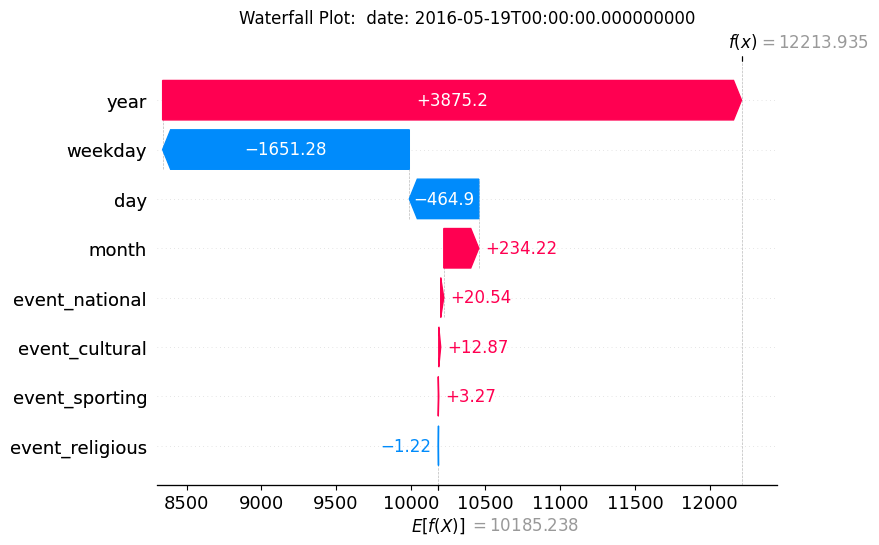

In [23]:
selected_ds = np.random.choice(shap_df[time_col].unique())

filtered_df = shap_df[shap_df[time_col] == selected_ds].iloc[:1]

shap_obj = shap.Explanation(
    values=filtered_df[shap_columns].values.flatten(),
    base_values=filtered_df['base_value'].values[0],
    feature_names=shap_columns
)

shap.plots.waterfall(shap_obj, show=False)

plt.title(f'Waterfall Plot:  date: {selected_ds}')
plt.show()